In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut

## 데이터 전처리

In [34]:
df_jinhyeok = pd.read_csv("./data/진혁_데이터프레임.csv")
df_jinhyeok.rename(columns={"Unnamed: 0":"행정구역","Unnamed: 1":"계절","Unnamed: 2":"연도"},inplace=True)

month_spring = ["_3","_4","_5"]           # ["_3","_4","_5"]
month_summer = ["_6","_7","_8"]      # ["_5","_6","_7","_8"]
month_fall = ["_8","_9","_10"]      # ["_8","_9","_10","_11"]
month_winter = ["_9","_10","_11"]      # ["_8","_9","_10","_11","_12","_1","_2"]

season = ["spring", "summer", "fall", "winter"]

for i in range(len(season)) : 
    globals()["df_"+season[i]] = df_jinhyeok[df_jinhyeok["계절"]==season[i]]  # 계절별로 데이터 프레임 형성
    globals()["df_"+season[i]] = globals()["df_"+season[i]].groupby(["행정구역","계절","연도"]).mean()   # 행정구역, 계절, 연도를 인덱스로 groupby

In [35]:
spr = "|".join(w for w in month_spring)

In [36]:
for i in range(len(season)) : 
    globals()["month_str_"+season[i]] = "|".join(w for w in globals()["month_"+season[i]])  # 각 계절별 월을 | 으로 join
    
    # 각 계절이 속하는 월과 면적, 생산이 속하는 컬럼명을 리스트로 저장
    globals()["col_of_"+season[i]] = globals()["df_"+season[i]].columns[globals()["df_"+season[i]].columns.str.contains(globals()["month_str_"+season[i]]+"|면적|생산")]

In [37]:
# 데이터프레임을 계절별로 분리
df_spring = df_spring[col_of_spring]
df_summer = df_summer[col_of_summer]
df_fall = df_fall[col_of_fall]
df_winter = df_winter[col_of_winter]

In [38]:
df_winter.dropna(how="any",inplace=True)
# df_winter

In [39]:
city = ["서울특별시", "부산광역시", "대구광역시", "인천광역시", "광주광역시", "대전광역시", "울산광역시", "세종특별자치시", "경기도", "강원도", "충청북도", "충청남도", "전라북도", "전라남도", "경상북도", "경상남도", "제주도"]
city = sorted(city)
# city

In [40]:
# df_winter[df_winter["생산량 (톤)"].isnull()]

In [41]:
# 생산량이 NaN인 행을 drop
df_spring.dropna(how="any", inplace=True)
df_summer.dropna(how="any", inplace=True)
df_fall.dropna(how="any", inplace=True)

In [42]:
# 면적 컬럼 삭제
for s in season : 
    globals()["df_"+s].drop(columns="면적 (ha)", inplace=True)

In [43]:
# 배추 생산 시기를 임의로 상, 중, 하로 나누었으며, 거기에는 육묘기, 생육기, 결구기 등이 포함돼 있음
for s in season : 
    globals()["df_"+s].columns = ['평균기온(°C)_상', '최고기온(°C)_상', '최저기온(°C)_상', '월합강수량(00~24h만)(mm)_상',
       '합계 일사량(MJ/m2)_상', '평균기온(°C)_중', '최고기온(°C)_중', '최저기온(°C)_중',
       '월합강수량(00~24h만)(mm)_중', '합계 일사량(MJ/m2)_중', '평균기온(°C)_하',
       '최고기온(°C)_하', '최저기온(°C)_하', '월합강수량(00~24h만)(mm)_하',
       '합계 일사량(MJ/m2)_하', '생산량 (톤)']

In [44]:
df_total = pd.concat([df_spring, df_summer, df_fall, df_winter])
df_total.head()

평균기온(°C)_상  최고기온(°C)_상  최저기온(°C)_상  월합강수량(00~24h만)(mm)_상  \
행정구역 계절     연도                                                               
강원도  spring 2000        4.40       19.30        -8.6                 14.10   
            2001        5.25       19.75        -8.6                  2.55   
            2002        7.30       19.70        -7.3                 33.10   
            2003        6.60       21.30        -6.0                 28.50   
            2004        6.90       20.30        -4.9                 19.90   

                  합계 일사량(MJ/m2)_상  평균기온(°C)_중  최고기온(°C)_중  최저기온(°C)_중  \
행정구역 계절     연도                                                          
강원도  spring 2000           448.65       10.40        23.7        -3.1   
            2001           455.28       10.85        23.7        -2.2   
            2002           519.21       12.70        24.8        -1.2   
            2003           523.00       11.90        25.9        -1.4   
            2004           481.75       12.60        25.4        -0.5   

                  월합강수량(00~24h만)(mm)_중  합계 일사량(MJ/m2)_중  평균기온(°C)_하  \
행정구역 계절     연도                                                        
강원도  spring 2000                 37.10          486.355       15.90   
            2001                 23.55          530.950       17.05   
            2002                 50.00          542.480       17.70   
            2003                 49.00          540.765       17.50   
            2004                 16.30          537.210       17.80   

                  최고기온(°C)_하  최저기온(°C)_하  월합강수량(00~24h만)(mm)_하  \
행정구역 계절     연도                                                   
강원도  spring 2000        31.6        3.90                 75.20   
            2001        31.4        5.55                 67.55   
            2002        34.1        5.70                 65.00   
            2003        34.5        5.60                 52.60   
            2004        33.9        5.80                 47.70   

                  합계 일사량(MJ/m2)_하   생산량 (톤)  
행정구역 계절     연도                               
강원도  spring 2000          520.280   87619.0  
            2001          562.770   83405.0  
            2002          586.320   56908.0  
            2003          586.195   82760.0  
            2004          540.490  100486.0

In [45]:
# df_total[df_total["생산량 (톤)"] == 0]

In [46]:
# 생산량이 0이상인 지역의 기후 조건을 적합, 0인 지역의 기후 조건을 부적합하다고 labeling
df_total["재배 적합"] = df_total["생산량 (톤)"].apply(lambda x : 1 if x > 0 else 0)

In [26]:
df_total[df_total["재배 적합"] == 0]
# df_total.head()

평균기온(°C)_상  최고기온(°C)_상  최저기온(°C)_상  월합강수량(00~24h만)(mm)_상  \
행정구역  계절     연도                                                               
대전광역시 spring 2012        7.30        19.8       -1.70                 53.90   
             2014        8.50        19.3       -2.20                 47.90   
             2015        6.00        17.4       -0.50                 45.80   
서울특별시 spring 2010        4.10        19.2       -5.50                 88.60   
             2011        3.20        18.7       -9.00                 26.70   
...                       ...         ...         ...                   ...   
충청북도  winter 2017       22.65        30.0       14.70                112.70   
             2018       22.10        30.2       13.50                139.90   
             2019       24.40        30.7       18.85                462.40   
             2020       21.75        29.7       13.15                210.95   
             2021       20.20        29.0       12.60                185.00   

                   합계 일사량(MJ/m2)_상  평균기온(°C)_중  최고기온(°C)_중  최저기온(°C)_중  \
행정구역  계절     연도                                                          
대전광역시 spring 2012          390.280       14.10       28.00        3.80   
             2014          427.520       13.80       28.40        3.20   
             2015          430.880       12.30       24.80        4.60   
서울특별시 spring 2010          343.625        9.20       24.80       -3.70   
             2011          506.250       10.10       22.60       -1.20   
...                            ...         ...         ...         ...   
충청북도  winter 2017          380.610       16.95       29.50        2.60   
             2018          415.265       15.60       30.60        0.90   
             2019          374.920       20.00       29.25        9.45   
             2020          440.290       14.95       29.75        0.30   
             2021          426.565       13.50       29.50       -1.70   

                   월합강수량(00~24h만)(mm)_중  합계 일사량(MJ/m2)_중  평균기온(°C)_하  \
행정구역  계절     연도                                                        
대전광역시 spring 2012                 38.50          496.970       17.70   
             2014                 78.20          443.545       17.70   
             2015                 48.50          523.180       15.70   
서울특별시 spring 2010                 70.50          494.850       16.70   
             2011                133.00          498.130       15.90   
...                                 ...              ...         ...   
충청북도  winter 2017                 29.50          433.200        9.95   
             2018                 43.20          423.275        8.90   
             2019                 32.75          409.190       14.05   
             2020                 42.80          388.865        7.95   
             2021                 33.80          407.200        6.40   

                   최고기온(°C)_하  최저기온(°C)_하  월합강수량(00~24h만)(mm)_하  \
행정구역  계절     연도                                                   
대전광역시 spring 2012       28.50        8.10                 97.70   
             2014       30.40        8.90                121.60   
             2015       27.30        8.10                 63.90   
서울특별시 spring 2010       30.80        1.50                110.00   
             2011       29.10        6.00                104.50   
...                       ...         ...                   ...   
충청북도  winter 2017       21.95       -1.45                 51.95   
             2018       22.60       -2.80                 86.40   
             2019       22.50        6.60                 59.40   
             2020       21.85       -3.75                 89.50   
             2021       19.90       -5.20                 44.90   

                   합계 일사량(MJ/m2)_하  생산량 (톤)  재배 적합  재배 부적합  
행정구역  계절     연도                                             
대전광역시 spring 2012          560.500      0.0      0       1  
             2014          527.260  

In [47]:
df_total.drop(columns="생산량 (톤)", inplace=True)
df_total.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1212 entries, ('강원도', 'spring', 2000) to ('충청북도', 'winter', 2021)
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   평균기온(°C)_상            1212 non-null   float64
 1   최고기온(°C)_상            1212 non-null   float64
 2   최저기온(°C)_상            1212 non-null   float64
 3   월합강수량(00~24h만)(mm)_상  1212 non-null   float64
 4   합계 일사량(MJ/m2)_상       1212 non-null   float64
 5   평균기온(°C)_중            1212 non-null   float64
 6   최고기온(°C)_중            1212 non-null   float64
 7   최저기온(°C)_중            1212 non-null   float64
 8   월합강수량(00~24h만)(mm)_중  1212 non-null   float64
 9   합계 일사량(MJ/m2)_중       1212 non-null   float64
 10  평균기온(°C)_하            1212 non-null   float64
 11  최고기온(°C)_하            1212 non-null   float64
 12  최저기온(°C)_하            1212 non-null   float64
 13  월합강수량(00~24h만)(mm)_하  1212 non-null   float64
 14  합계 일사량(MJ/m2)_하       1212 non

<AxesSubplot:>

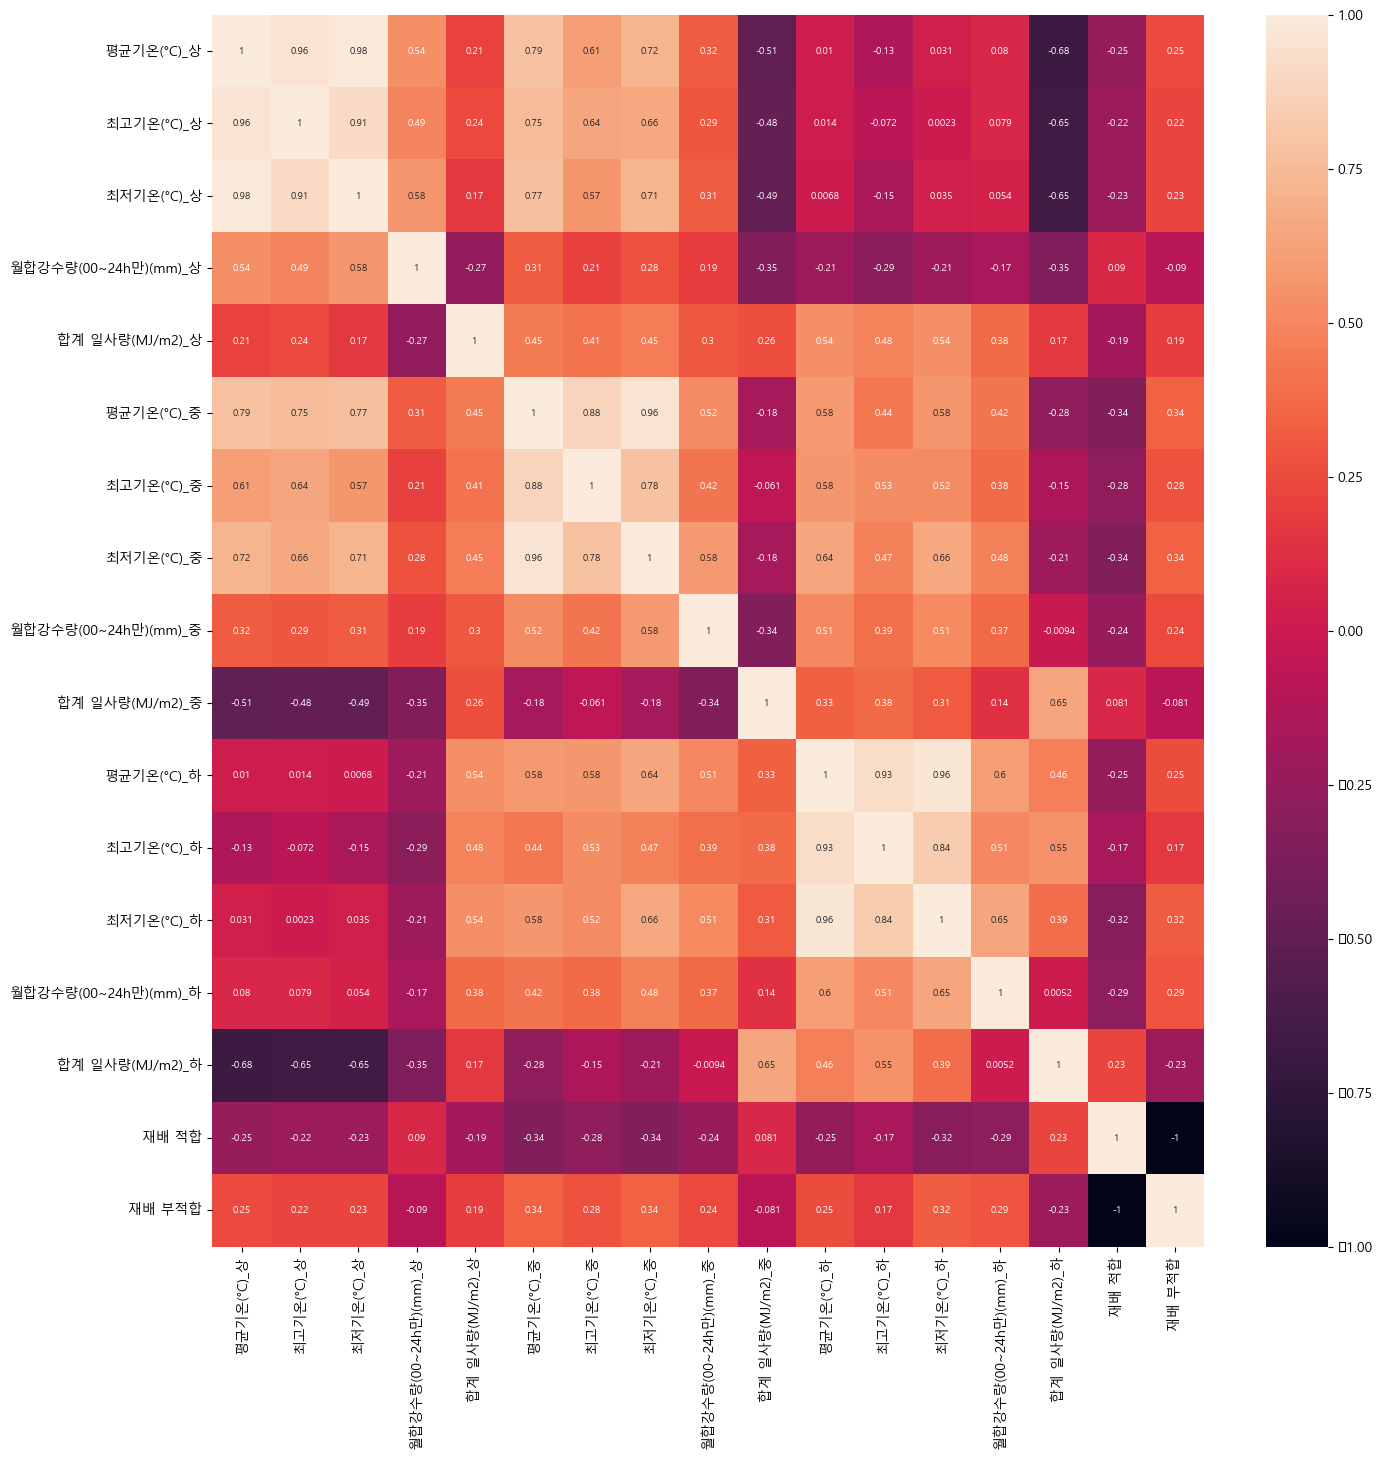

In [30]:
# 상관 분석(안 해도 되나)
# plt.rc('font', family='Malgun Gothic')

# corr = np.corrcoef(df_total.values.T)
# fig = plt.figure(figsize=(16,16))
# sns.heatmap(corr, cbar=True, annot=True, square=False, xticklabels=df_total.columns, yticklabels=df_total.columns, annot_kws={"size":7})

## train, test set 분리

In [54]:
X = df_total.iloc[:,:-1]
y = df_total.iloc[:,-1:]

In [55]:
std = StandardScaler()
std.fit(X)
X = std.transform(X)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## logistic regression을 통한 이진분류

In [59]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("accuracy :", accuracy_score(y_test, y_pred))

accuracy : 0.7489711934156379


In [61]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("accuracy :", accuracy_score(y_test, y_pred))

accuracy : 0.9300411522633745


In [63]:
df_summer

평균기온(°C)_상  최고기온(°C)_상  최저기온(°C)_상  월합강수량(00~24h만)(mm)_상  \
행정구역 계절     연도                                                               
강원도  summer 2000       21.30       33.60        9.60                116.90   
            2001       22.70       33.35       12.65                113.60   
            2002       21.90       32.80       12.20                133.50   
            2003       21.90       34.90        9.50                111.50   
            2004       22.50       32.70       13.60                197.70   
...                      ...         ...         ...                   ...   
충청북도 summer 2017       22.30       30.50       13.60                114.75   
            2018       22.40       32.40       13.10                124.20   
            2019       22.65       30.45       17.85                182.55   
            2020       22.00       32.15       11.85                 69.20   
            2021       21.30       31.40       10.00                 76.80   

                  합계 일사량(MJ/m2)_상  평균기온(°C)_중  최고기온(°C)_중  최저기온(°C)_중  \
행정구역 계절     연도                                                          
강원도  summer 2000          547.195       24.90       34.30       16.70   
            2001          554.200       25.75       34.05       18.80   
            2002          471.260       25.80       34.10       18.40   
            2003          504.755       24.90       35.10       16.50   
            2004          359.160       26.50       34.30       20.30   
...                           ...         ...         ...         ...   
충청북도 summer 2017          627.600       26.40       33.40       19.10   
            2018          615.065       26.60       34.90       19.60   
            2019          587.170       26.65       33.10       22.05   
            2020          590.215       26.50       34.80       19.50   
            2021          605.000       25.40       34.20       17.90   

                  월합강수량(00~24h만)(mm)_중  합계 일사량(MJ/m2)_중  평균기온(°C)_하  \
행정구역 계절     연도                                                        
강원도  summer 2000                153.40          512.230        24.1   
            2001                244.00          542.240        25.0   
            2002                384.00          529.200        25.7   
            2003                179.60          491.390        24.3   
            2004                321.40          305.840        26.3   
...                                ...              ...         ...   
충청북도 summer 2017                435.20          574.890        25.9   
            2018                223.20          584.155        25.3   
            2019                218.40          512.410        26.5   
            2020                126.45          623.480        25.1   
            2021                217.10          639.565        23.8   

                  최고기온(°C)_하  최저기온(°C)_하  월합강수량(00~24h만)(mm)_하  \
행정구역 계절     연도                                                   
강원도  summer 2000       33.70       17.40                348.00   
            2001       34.00       18.25                417.40   
            2002       34.60       19.70                415.00   
            2003       34.00       17.60                244.60   
            2004       33.90       18.70                538.30   
...                      ...         ...                   ...   
충청북도 summer 2017       34.30       19.00                275.40   
            2018       34.00       18.90                358.70   
            2019       33.15       21.70                273.10   
            2020       34.25       18.30                241.85   
            2021       33.90       17.50                239.90   

                  합계 일사량(MJ/m2)_하   생산량 (톤)  
행정구역 계절     연도                               
강원도  summer 2000          412.735  281280.0  
            2001          453.020  290571.0  
            2002          463.430  215921.0  
            2003          414.440  23828

In [64]:
test = [21.65,31.45,18.85,100.55,600.170,28.65,35.10,21.05,218.40,512.410,20.5,28.15,17.70,400.10,280.075]
test_array = np.array(test).reshape(1,-1)

In [65]:
rf.predict(test_array)

array([0], dtype=int64)